In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Lib.module.risk_budgeting import *
import student_mixture as sm
from tqdm import tqdm
from Lib.module.movidas import *

In [2]:
from scipy.optimize import minimize

def rb_vol(covariance_matrix, budgets):
    def objective(x):
        return (np.dot(x,np.dot(covariance_matrix, x)) - np.dot(budgets, np.log(x)))
    x0 = np.ones(len(budgets))
    bnds = [(1e-8,None) for _ in range(len(budgets))]
    res = minimize(objective, x0, bounds=bnds)
    return res.x, res.fun

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
freq = 'B'
df_all = pd.concat([pd.read_excel('Data/SP_RC.xlsx',index_col=0, header=[0,1]), pd.read_excel('Data/SP_RC2.xlsx',index_col=0, header=[0,1])])
df_all = df_all.dropna(how='all').dropna(axis=1)
df_all = df_all.pct_change().dropna()
df_all = df_all.replace([np.inf, -np.inf], np.nan)
df_all = df_all[~df_all.index.duplicated(keep='first')]
first_level_index = df_all.columns.get_level_values(0)

Volatility

In [319]:
d = 250 # number of assets 10,25,50,100,250

selected_indices = np.random.choice(range(len(first_level_index)), d, replace = False)
assets = first_level_index[selected_indices]
nb_asset = len(assets)
df = df_all[assets]
X = df.values

### Fit Student-t mixture (2 components) to chosen stock returns
n_sm = 1
SM_model = sm.StudentMixture(n_components=n_sm, fixed_dofs = True, dofs_init = [4]).fit(X)
SM_model.locations_ = np.array([np.zeros(nb_asset)])

# ERC
budgets = np.ones(nb_asset)/nb_asset 

y_ref, _ = rb_vol(SM_model.scales_[0], budgets)
SM_theta = y_ref/y_ref.sum()

n_val=500000
X = SM_model.rvs(n_val)
np.random.shuffle(X)

gamma_sgd = 3.2
gamma_smd = .8

y_sgd = d**.5 * budgets / np.std(X, axis=0)
xi_sgd = 0
c_sgd = .65

y_smd = d**.5 * budgets / np.std(X, axis=0)
xi_smd = 0
c_smd = .65
M = 10000

y_sgd_s = [y_sgd]
xi_sgd_s = [xi_sgd]


y_smd_s = [y_smd]
xi_smd_s = [xi_smd]

freq_y = 10000

for k in tqdm(range(1, n_val)):
    x = X[k]
    
    ### SGD
    # gradient
    step_size_sgd = gamma_sgd/k**c_sgd
    grad_y_sgd = 2 * (np.dot(y_sgd,x) - xi_sgd)*x - d*budgets/y_sgd
    grad_xi_sgd = -2 * (np.dot(y_sgd,x) - xi_sgd)

    #descent
    y_sgd = y_sgd - step_size_sgd*grad_y_sgd*min(min(y_sgd),1)
    y_sgd = np.where(y_sgd <= 0, 1, y_sgd)
    xi_sgd = xi_sgd - step_size_sgd*grad_xi_sgd
    # y_bar_sgd_numerator += y_sgd*step_size_sgd
    # y_bar_sgd_denominator += step_size_sgd

    ### SMD
    # gradient
    step_size_smd = gamma_smd/k**c_smd
    grad_y_smd = 2 * (np.dot(y_smd,x) - xi_smd)*x - d*budgets/y_smd
    grad_xi_smd = -2 * (np.dot(y_smd,x) - xi_smd)

    y_smd_min = min(min(y_smd),1)
    y_smd = y_smd*np.exp(-step_size_smd*y_smd_min*grad_y_smd)
    xi_smd = xi_smd - step_size_smd*grad_xi_smd
    sum_y_smd = np.sum(y_smd)
    if sum_y_smd>M:
        y_smd = M/sum_y_smd*y_smd

    if k%freq_y==0:
        y_sgd_s.append(y_sgd)
        xi_sgd_s.append(xi_sgd)
        y_smd_s.append(y_smd)
        xi_smd_s.append(xi_smd)

100%|██████████| 499999/499999 [00:30<00:00, 16460.18it/s]


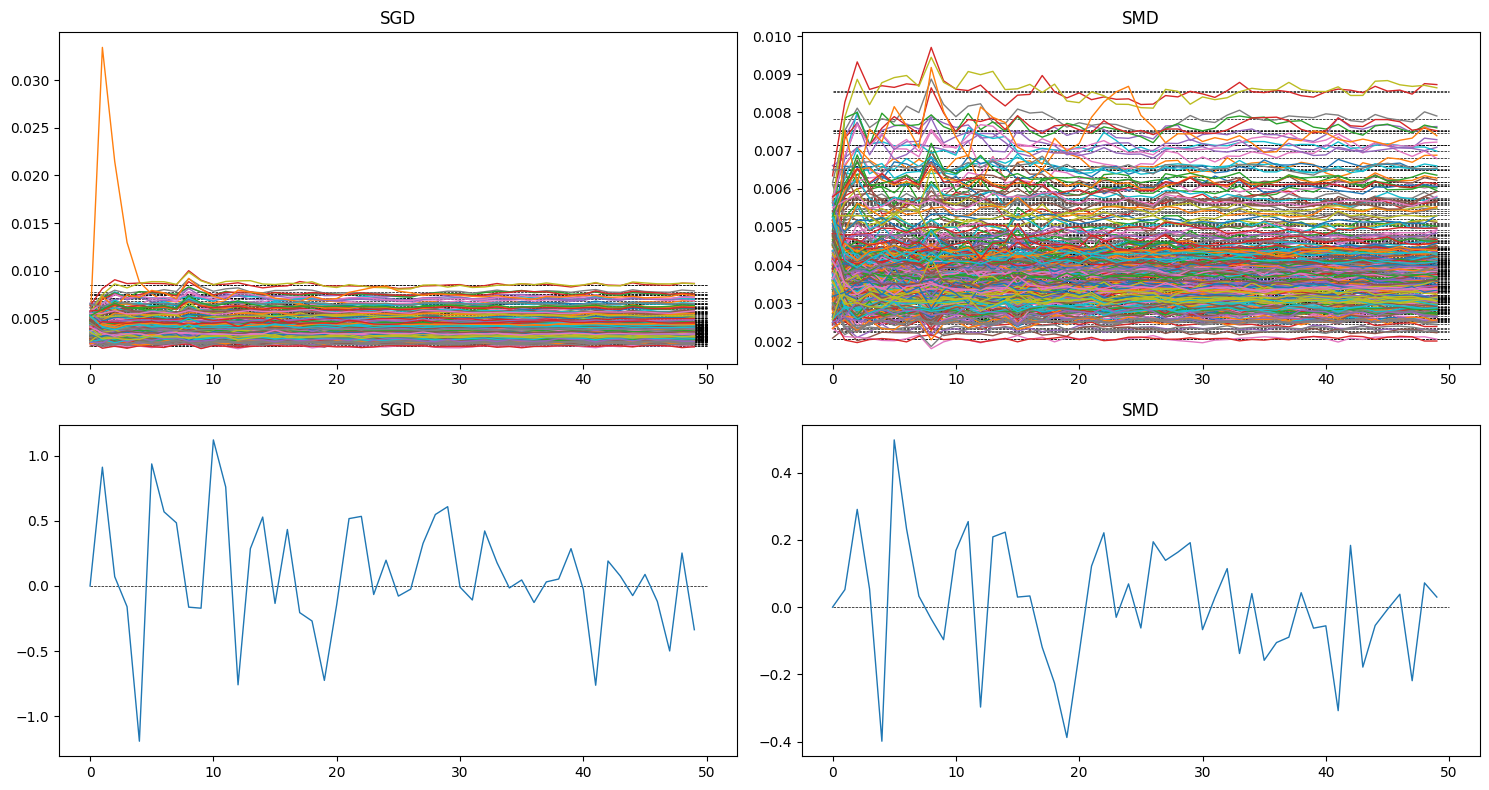

In [320]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax[0][0].plot((np.array(y_sgd_s)/np.array(y_sgd_s).sum(axis=1)[:,None])[:], lw=1)
ax[0][0].set_title('SGD')
ax[0][1].plot((np.array(y_smd_s)/np.array(y_smd_s).sum(axis=1)[:,None])[:], lw=1)
ax[0][1].set_title('SMD')
ax[0][0].hlines(SM_theta, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[0][1].hlines(SM_theta, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[0].set_ylim(0, 100) 
# ax[1].set_ylim(0, 20) 

ax[1][0].plot(xi_sgd_s, lw=1)
ax[1][0].set_title('SGD')
ax[1][1].plot(xi_smd_s, lw=1)
ax[1][1].set_title('SMD')
ax[1][0].hlines(0, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[1][1].hlines(0, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[2].set_ylim(0, 100)
# ax[3].set_ylim(0, 20)
plt.tight_layout()
plt.show()

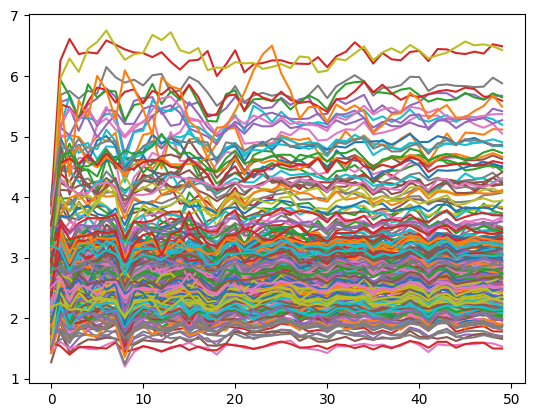

In [322]:
plt.plot(np.array(y_smd_s))

Variantile

In [459]:
d = 250

selected_indices = np.random.choice(range(len(first_level_index)), d, replace = False)
assets = first_level_index[selected_indices]
nb_asset = len(assets)
df = df_all[assets]
X = df.values

### Fit Student-t mixture (2 components) to chosen stock returns
n_sm = 1
SM_model = sm.StudentMixture(n_components=n_sm, fixed_dofs = True, dofs_init = [4]).fit(X)
SM_model.locations_ = np.array([np.zeros(nb_asset)])

# ERC
budgets = np.ones(nb_asset)/nb_asset 

y_ref, _ = rb_vol(SM_model.scales_[0], budgets)
SM_theta = y_ref/y_ref.sum()

n_val=500000
X = SM_model.rvs(n_val)
np.random.shuffle(X)

alpha = .75

gamma_sgd = 8
gamma_smd = 1

y_sgd = np.ones(d)*100/d**.5
xi_sgd = 0
c_sgd = .65

y_smd = np.ones(d)*100/d**.5
xi_smd = 0
c_smd = .65
M = 10000

y_sgd_s = [y_sgd]
xi_sgd_s = [xi_sgd]


y_smd_s = [y_smd]
xi_smd_s = [xi_smd]

freq_y = 10000

for k in tqdm(range(1, n_val)):
    x = X[k]
    
    ### SGD
    # gradient
    step_size_sgd = gamma_sgd/k**c_sgd
    loss_sgd = -np.dot(y_sgd, x)
    indicator_pos_sgd = loss_sgd - xi_sgd >= 0
    indicator_neg_sgd = loss_sgd - xi_sgd < 0
    grad_y_sgd = -2 * alpha * (loss_sgd - xi_sgd) * x * indicator_pos_sgd + -2 * (1 - alpha) * (loss_sgd - xi_sgd) * x * indicator_neg_sgd - d*budgets/y_sgd
    grad_xi_sgd = -2 * alpha * (loss_sgd - xi_sgd) * indicator_pos_sgd + -2 * (1 - alpha) * (loss_sgd - xi_sgd) * indicator_neg_sgd

    #descent
    y_sgd = y_sgd - step_size_sgd*grad_y_sgd*min(min(y_sgd),1)
    y_sgd = np.where(y_sgd <= 0, 1, y_sgd)
    xi_sgd = xi_sgd - step_size_sgd*grad_xi_sgd
    # y_bar_sgd_numerator += y_sgd*step_size_sgd
    # y_bar_sgd_denominator += step_size_sgd

    ### SMD
    # gradient
    step_size_smd = gamma_smd/k**c_smd
    loss_smd = -np.dot(y_smd, x)
    indicator_pos_smd = loss_smd - xi_smd >= 0
    indicator_neg_smd = loss_smd - xi_smd < 0
    grad_y_smd = -2 * alpha * (loss_smd - xi_smd) * x * indicator_pos_smd + -2 * (1 - alpha) * (loss_smd - xi_smd) * x * indicator_neg_smd - d*budgets/y_smd
    grad_xi_smd = -2 * alpha * (loss_smd - xi_smd) * indicator_pos_smd + -2 * (1 - alpha) * (loss_smd - xi_smd) * indicator_neg_smd

    y_smd_min = min(min(y_smd),1)
    y_smd = y_smd*np.exp(-step_size_smd*y_smd_min*grad_y_smd)
    xi_smd = xi_smd - step_size_smd*grad_xi_smd
    sum_y_smd = np.sum(y_smd)
    if sum_y_smd>M:
        y_smd = M/sum_y_smd*y_smd

    if k%freq_y==0:
        y_sgd_s.append(y_sgd)
        xi_sgd_s.append(xi_sgd)
        y_smd_s.append(y_smd)
        xi_smd_s.append(xi_smd)

100%|██████████| 499999/499999 [00:39<00:00, 12628.09it/s]


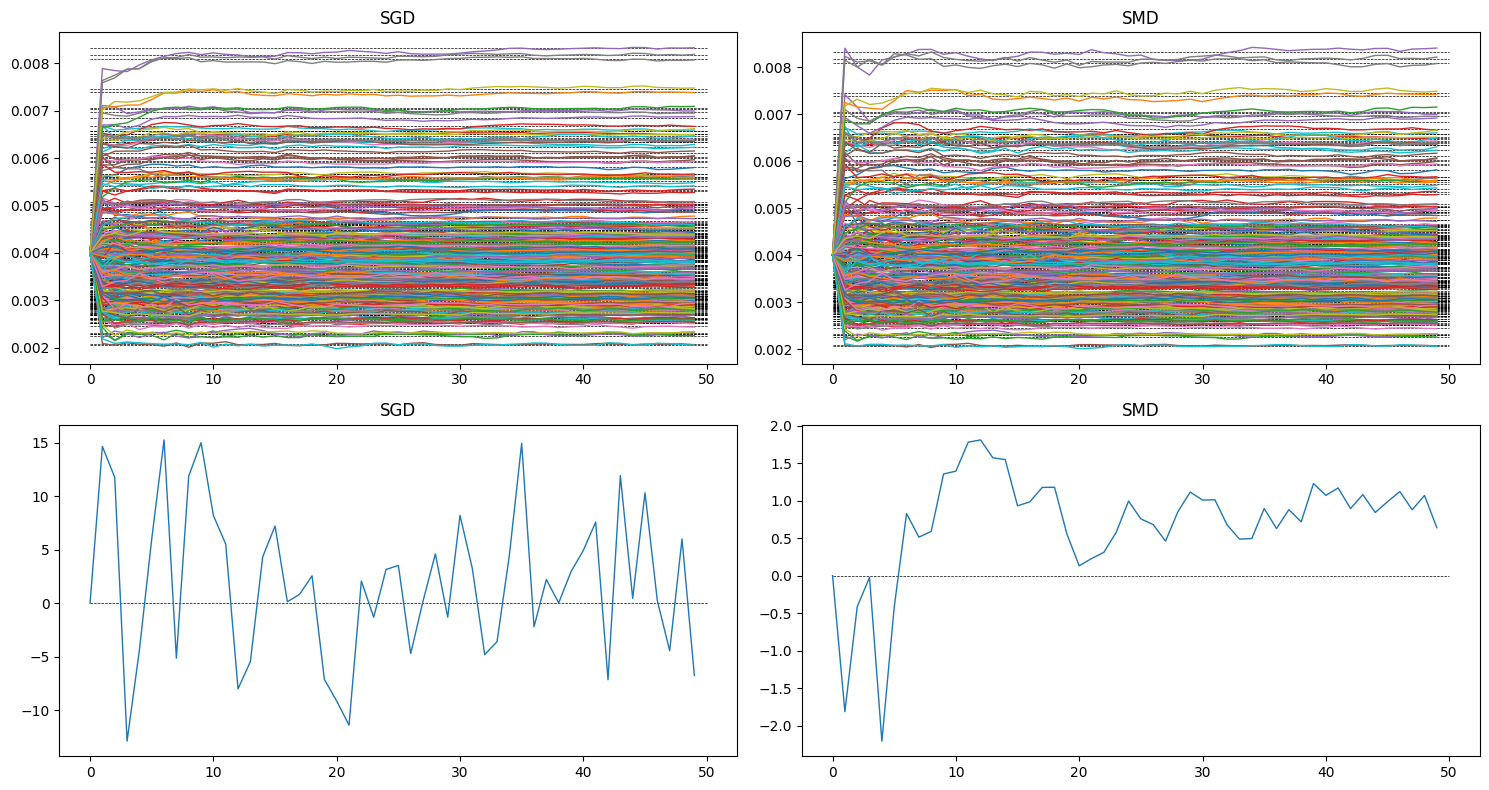

In [496]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax[0][0].plot(np.array(y_sgd_s)/np.array(y_sgd_s).sum(axis=1)[:,None], lw=1)
ax[0][0].set_title('SGD')
ax[0][1].plot(np.array(y_smd_s)/np.array(y_smd_s).sum(axis=1)[:,None], lw=1)
ax[0][1].set_title('SMD')
ax[0][0].hlines(SM_theta, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[0][1].hlines(SM_theta, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[0].set_ylim(0, 100) 
# ax[1].set_ylim(0, 20) 

ax[1][0].plot(xi_sgd_s, lw=1)
ax[1][0].set_title('SGD')
ax[1][1].plot(xi_smd_s, lw=1)
ax[1][1].set_title('SMD')
ax[1][0].hlines(0, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[1][1].hlines(0, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[2].set_ylim(0, 100)
# ax[3].set_ylim(0, 20)
plt.tight_layout()
plt.show()

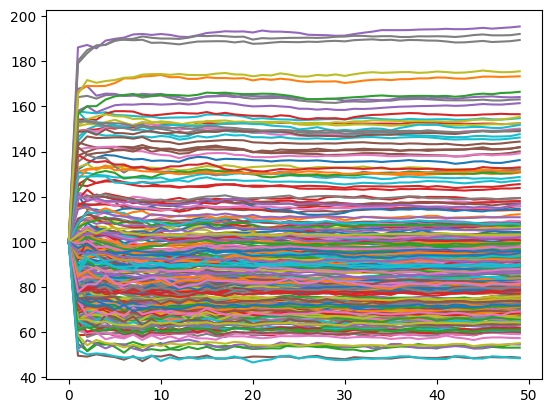

In [497]:
plt.plot(np.array(y_sgd_s))


In [462]:
sum(y_smd)

1167.7860641428795

MAD

In [504]:
d = 10

selected_indices = np.random.choice(range(len(first_level_index)), d, replace = False)
assets = first_level_index[selected_indices]
nb_asset = len(assets)
df = df_all[assets]
X = df.values

### Fit Student-t mixture (1 components) to chosen stock returns
n_sm = 1
SM_model = sm.StudentMixture(n_components=n_sm, fixed_dofs = True, dofs_init = [4]).fit(X)
SM_model.locations_ = np.array([np.zeros(nb_asset)])

# ERC
budgets = np.ones(nb_asset)/nb_asset 

y_ref, _ = rb_vol(SM_model.scales_[0], budgets)
SM_theta = y_ref/y_ref.sum()

n_val=500000
X = SM_model.rvs(n_val)
np.random.shuffle(X)

gamma_sgd = 750
gamma_smd = 5

# y_sgd = d * budgets / np.std(X, axis=0)
y_sgd = np.ones(d)*100
xi_sgd = 0
c_sgd = .65

# y_smd = d * budgets / np.std(X, axis=0)
y_smd = np.ones(d)*100
xi_smd = 0
c_smd = .65
M = 100000

y_sgd_s = [y_sgd]
xi_sgd_s = [xi_sgd]


y_smd_s = [y_smd]
xi_smd_s = [xi_smd]

freq_y = 10000

for k in tqdm(range(1, n_val)):
    x = X[k]
    
    ### SGD
    # gradient
    step_size_sgd = gamma_sgd/k**c_sgd
    loss_sgd = -np.dot(y_sgd, x)
    indicator_pos_sgd = (loss_sgd - xi_sgd >= 0)*1
    indicator_neg_sgd = 1 - indicator_pos_sgd
    grad_y_sgd = (indicator_neg_sgd - indicator_pos_sgd)*x - d*budgets/y_sgd
    grad_xi_sgd = indicator_neg_sgd - indicator_pos_sgd

    #descent
    y_sgd = y_sgd - step_size_sgd*grad_y_sgd*min(min(y_sgd),1)
    y_sgd = np.where(y_sgd <= 0, 1, y_sgd)
    xi_sgd = xi_sgd - step_size_sgd*grad_xi_sgd
    # y_bar_sgd_numerator += y_sgd*step_size_sgd
    # y_bar_sgd_denominator += step_size_sgd

    ### SMD
    # gradient
    step_size_smd = gamma_smd/k**c_smd
    loss_smd = -np.dot(y_smd, x)
    indicator_pos_smd = (loss_smd - xi_smd >= 0)*1
    indicator_neg_smd = 1-indicator_pos_smd
    grad_y_smd = (indicator_neg_smd - indicator_pos_smd)*x - d*budgets/y_smd 
    grad_xi_smd = indicator_neg_smd - indicator_pos_smd

    y_smd_min = min(min(y_smd),1)
    y_smd = y_smd*np.exp(-step_size_smd*y_smd_min*grad_y_smd)
    xi_smd = xi_smd - step_size_smd*grad_xi_smd
    sum_y_smd = np.sum(y_smd)
    if sum_y_smd>M:
        y_smd = M/sum_y_smd*y_smd

    if k%freq_y==0:
        y_sgd_s.append(y_sgd)
        xi_sgd_s.append(xi_sgd)
        y_smd_s.append(y_smd)
        xi_smd_s.append(xi_smd)

100%|██████████| 499999/499999 [00:16<00:00, 31014.29it/s]


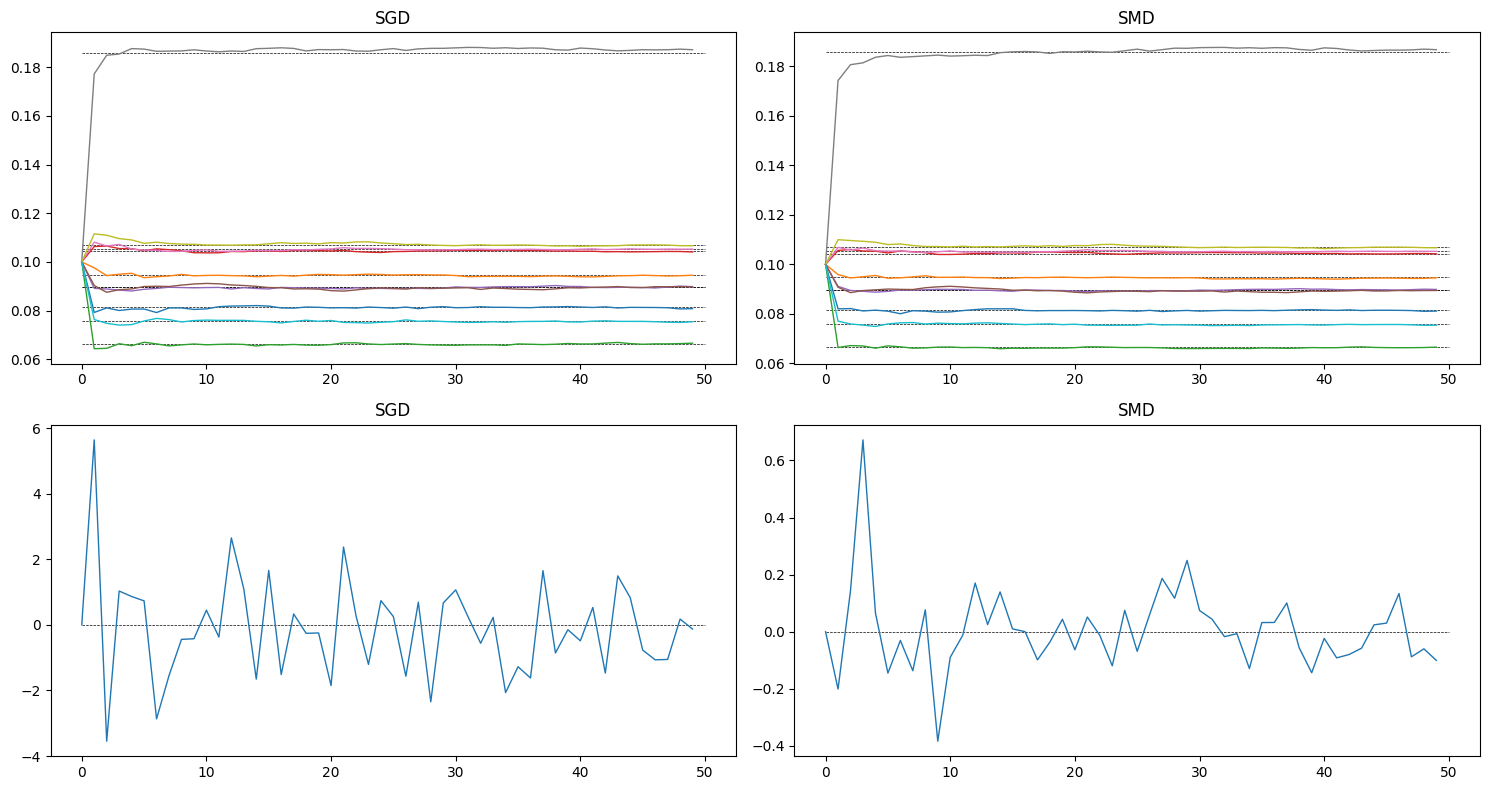

In [505]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax[0][0].plot(np.array(y_sgd_s)/np.array(y_sgd_s).sum(axis=1)[:,None], lw=1)
ax[0][0].set_title('SGD')
ax[0][1].plot(np.array(y_smd_s)/np.array(y_smd_s).sum(axis=1)[:,None], lw=1)
ax[0][1].set_title('SMD')
ax[0][0].hlines(SM_theta, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[0][1].hlines(SM_theta, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[0].set_ylim(0, 100) 
# ax[1].set_ylim(0, 20) 

ax[1][0].plot(xi_sgd_s, lw=1)
ax[1][0].set_title('SGD')
ax[1][1].plot(xi_smd_s, lw=1)
ax[1][1].set_title('SMD')
ax[1][0].hlines(0, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[1][1].hlines(0, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[2].set_ylim(0, 100)
# ax[3].set_ylim(0, 20)
plt.tight_layout()
plt.show()

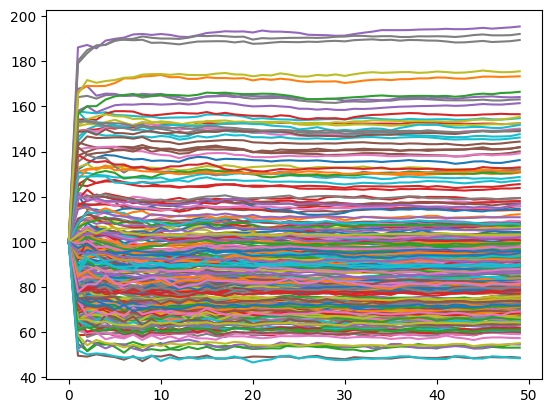

In [499]:
plt.plot(np.array(y_sgd_s))

In [384]:
sum(y_smd)

1272.3920312258995